# Reduction du bruit aéronautique 

### Introduction

Ce notebook a pour but de présenter les différents filtres conçus dans le but de réduire le bruit de nos audios. L'objectif principal n'est pas ici de "nettoyer" les données audio afin d'obtenir le signal sonore le plus propre mais plutôt de rechercher un rapport qualité reconnaissance vocale / temps de traitement des données le plus optimal possible. 

Aussi ce notebook aura pour but de détailler l'élaboration des différents filtres puis de tester leurs performances sur un dataset noisy_data qui comprend un échantillon de 10 audios jugés très bruités comparés aux autres.

In [11]:
#Import des bibliothèques
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile  # Pour lire un fichier audio
import wave
import librosa
import os
from IPython.display import Audio, IFrame, display
from scipy import fft

Lisons d'abord nos enregistrements :

In [6]:
# Chemin vers le dossier contenant les fichiers audio WAV
dossier_audio = 'noisy_data'

# Fréquence d'échantillonnage souhaitée
sr = 16000

# Liste pour stocker les signaux audio et les noms des fichiers
audio_list = []

# Parcours des fichiers dans le dossier
for filename in os.listdir(dossier_audio):
    if filename.endswith('.wav'):  # Vérifie l'extension du fichier
        filepath = os.path.join(dossier_audio, filename)  # Chemin complet du fichier
        # Chargement du fichier audio
        y, _ = librosa.load(filepath, mono=True, sr=sr)
        audio_list.append((y, sr, filename))  # Ajoute le signal audio et le nom du fichier à la liste

# Maintenant, audio_list contient tous les signaux audio chargés et leur nom de fichier correspondant


In [7]:
# Affichage de tous les fichiers audio de la liste audio_list
for audio_data in audio_list:
    display(Audio(audio_data[0], rate=audio_data[1]))

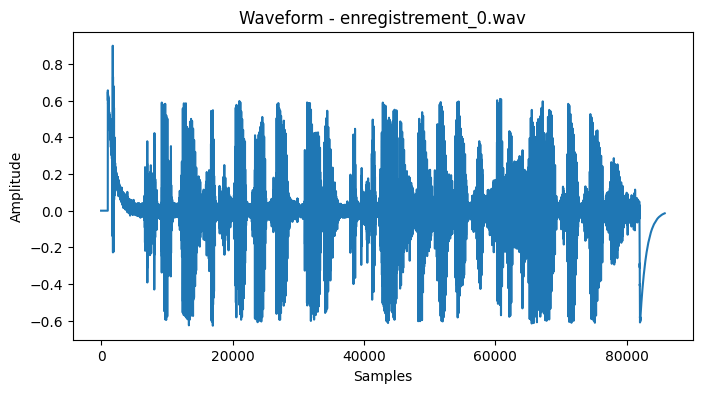

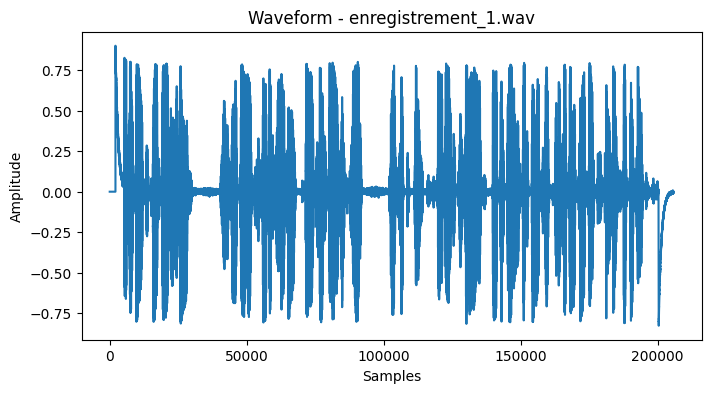

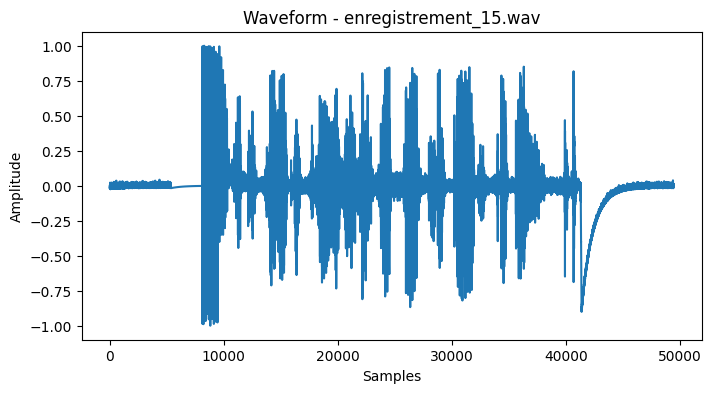

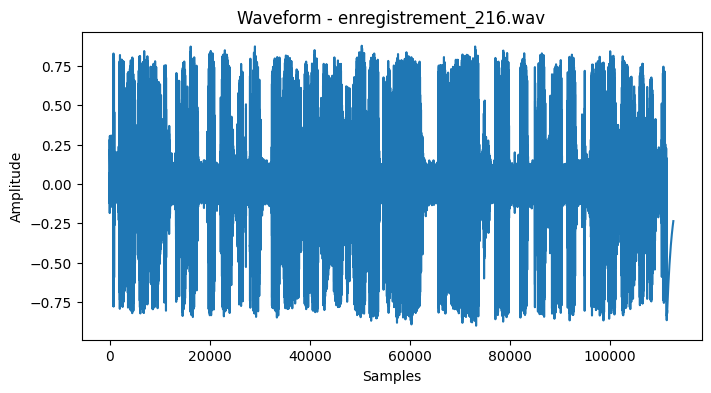

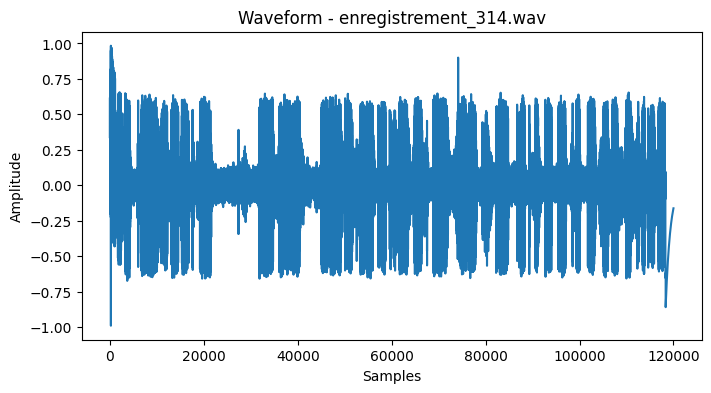

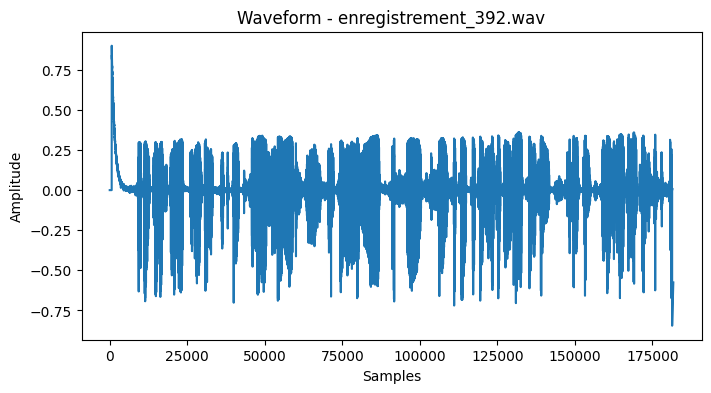

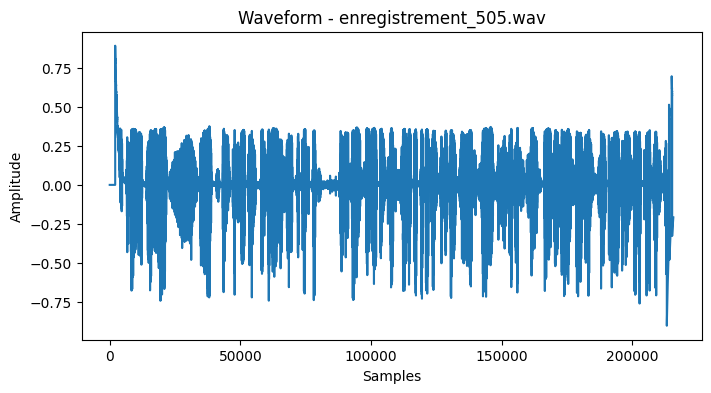

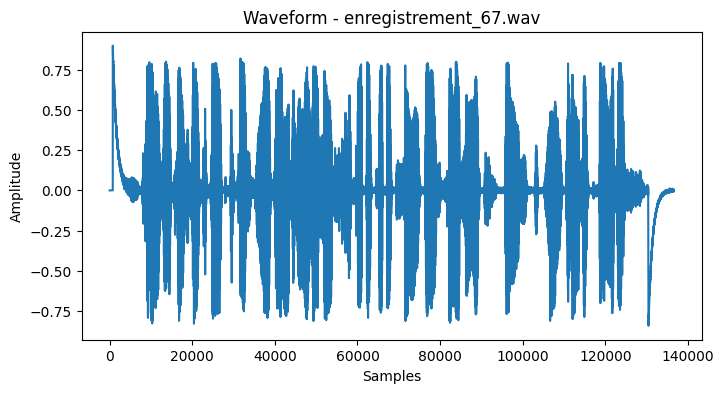

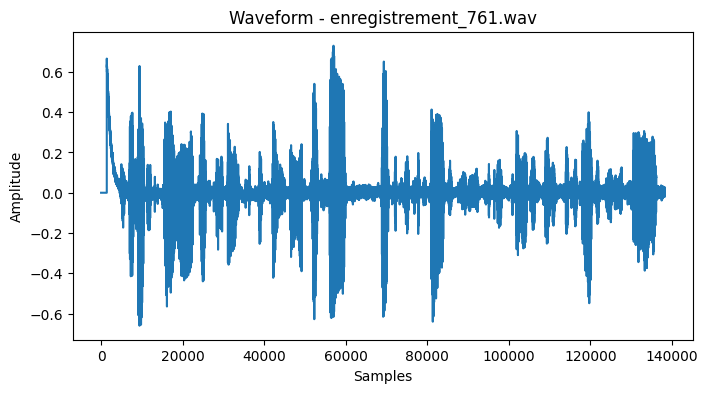

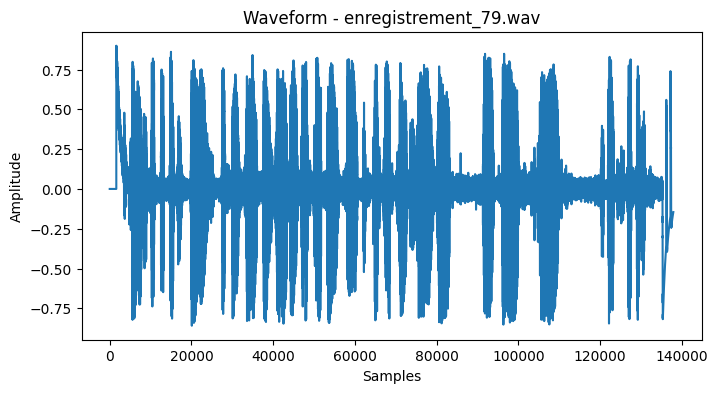

In [9]:
# Affichage de la forme d'onde pour tous les fichiers audio de la liste audio_list
for audio_data in audio_list:
    y = audio_data[0]  # Signal audio
    sr = audio_data[1]  # Fréquence d'échantillonnage
    filename = audio_data[2]  # Nom du fichier
    
    plt.figure(figsize=(8, 4))
    plt.plot(y)
    plt.title(f'Waveform - {filename}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

### Elaboration des méthodes de réduction de bruit

#### 1ère méthode : filtre passe-bande 

Une première méthode que nous qualifierons de niaise consiste à essayer de construire un filtre passe-bande qui va essayer de ne récupérer que les fréquences correspondants à la voix du pilote. D'après le site de wikipédia (https://fr.wikipedia.org/wiki/Spectre_sonore), on sait que le spectre de la voix humaine transmise par téléhone est compris entre 300 Hz et 3400 Hz.

Partant de cette base, nous avons effectué divers tests à la main afin de récupérer la bande de fréquence avec le meilleur rendu audio possible perçu par une oreille humaine. C'est certes un point de vue qualitatif mais c'était selon nous le plus pertinent à ce moment-là. Il pourra de plus être discuté dans les prochaines parties ou en conclusion.

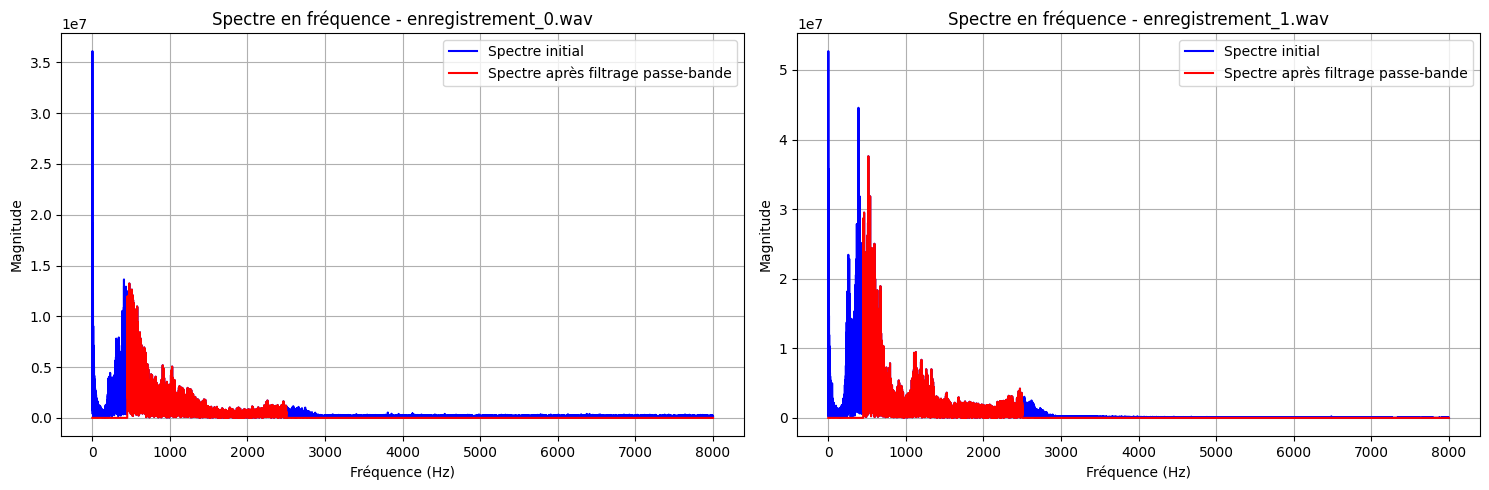

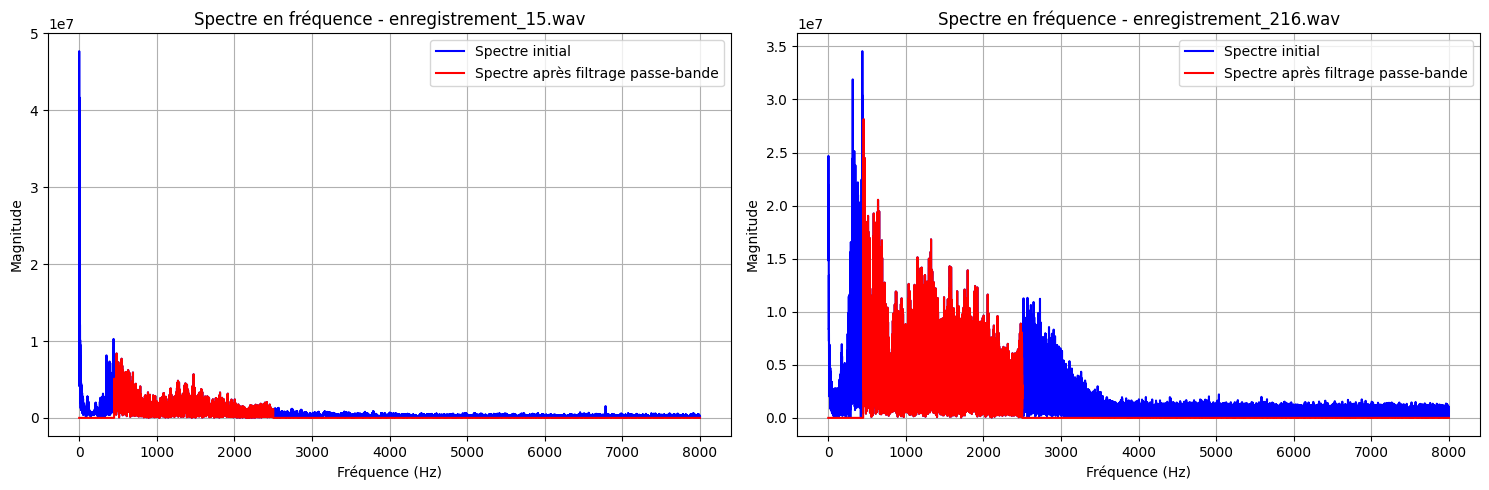

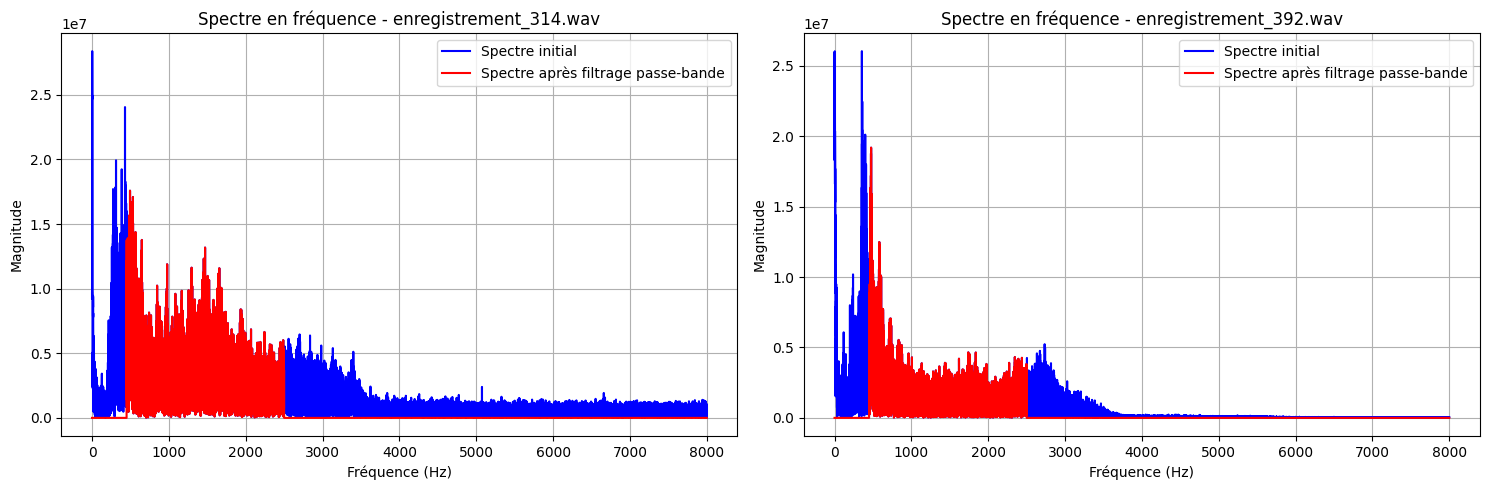

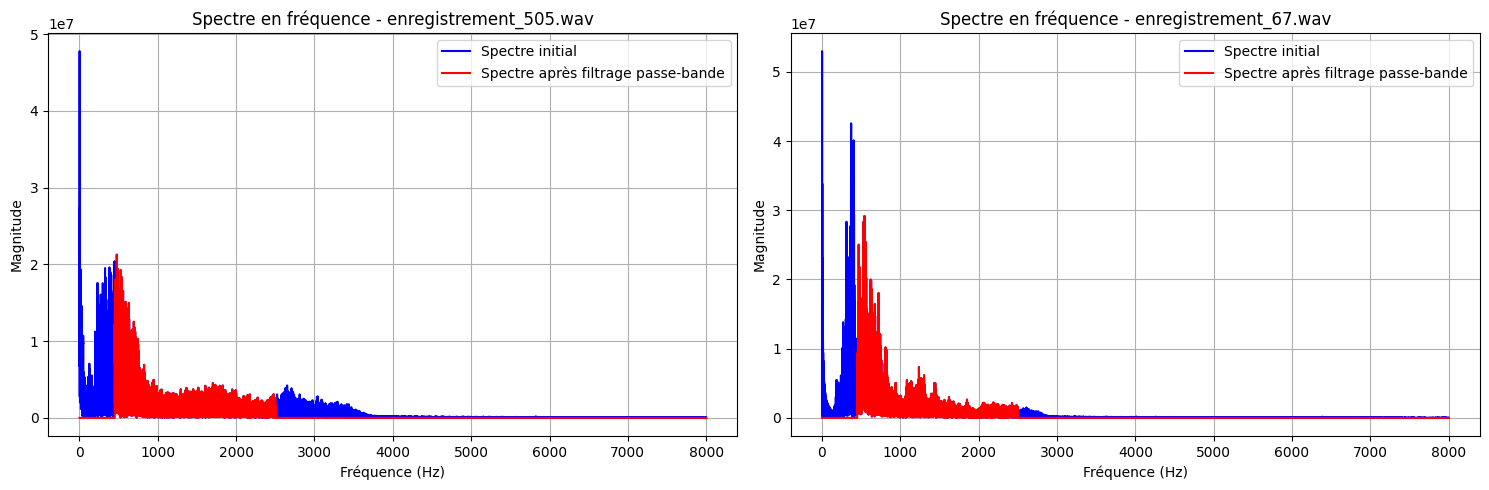

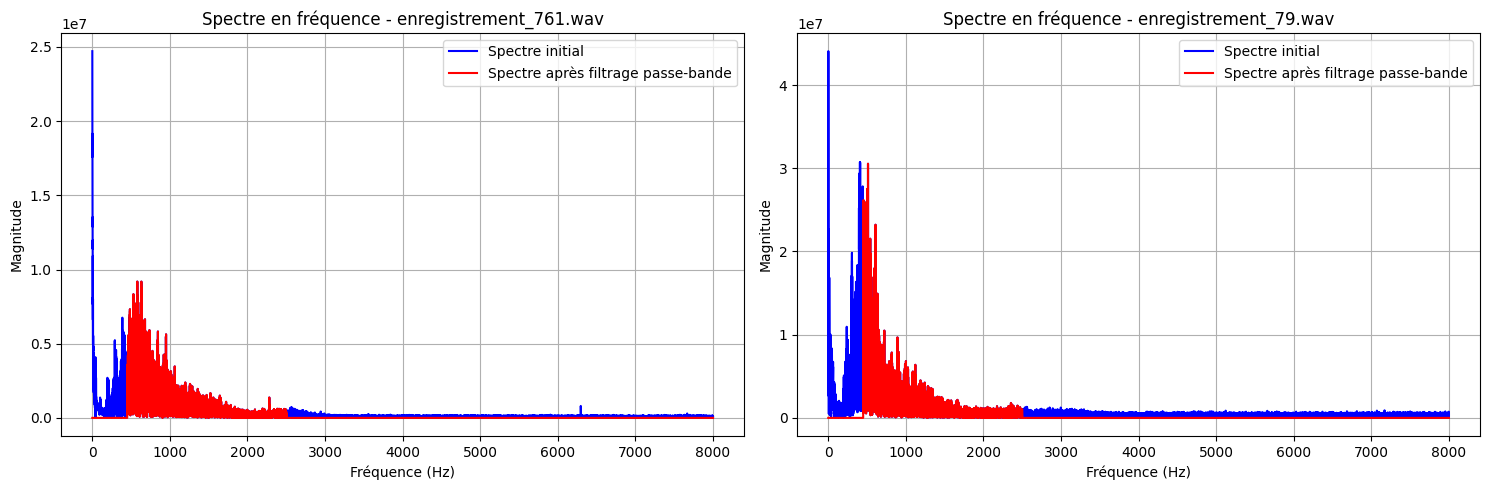

In [16]:
# Chemin vers le dossier contenant les fichiers audio WAV
dossier_audio = 'noisy_data'
output_folder = 'data_filtered_met1'

# Création du dossier pour les fichiers audio filtrés s'il n'existe pas déjà
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Fréquences de coupure du passe-bande
low_cutoff = 450  # Fréquence de coupure inférieure
high_cutoff = 2500  # Fréquence de coupure supérieure

# Liste pour stocker les noms de fichiers traités
processed_files = []

# Parcours de chaque fichier dans le dossier noisy_data
for filename in os.listdir(dossier_audio):
    if filename.endswith('.wav'):  # Vérifie l'extension du fichier
        filepath = os.path.join(dossier_audio, filename)  # Chemin complet du fichier

        # Lecture du fichier audio
        sample_rate, audio_data = wavfile.read(filepath)

        # Calcul de la FFT
        fft_result = np.fft.fft(audio_data)

        # Calcul des fréquences correspondantes
        frequencies = np.fft.fftfreq(len(fft_result), 1.0 / sample_rate)

        # On ignore les fréquences négatives et on prend seulement la moitié des résultats (car la FFT est symétrique)
        positive_frequencies = frequencies[:len(frequencies) // 2]

        # Création d'un filtre passe-bande
        filter_indices = np.where((positive_frequencies >= low_cutoff) & (positive_frequencies <= high_cutoff))
        fft_result_bandpass = np.zeros_like(fft_result)
        fft_result_bandpass[filter_indices] = fft_result[filter_indices]

        # Reconstruction du signal filtré avec l'inverse de la FFT
        audio_data_bandpass = np.fft.ifft(fft_result_bandpass).real

        # Normalisation et sauvegarde du fichier audio filtré dans le dossier spécifique
        scaled = np.int16(audio_data_bandpass / np.max(np.abs(audio_data_bandpass)) * 32767)
        output_file_path = os.path.join(output_folder, f'audio_filtre_{filename[:-4]}_V{low_cutoff}_{high_cutoff}.wav')
        wavfile.write(output_file_path, sample_rate, scaled)

        # Tracé du spectre en fréquence initial et après filtrage
        magnitude = np.abs(fft_result)[:len(frequencies) // 2]

        processed_files.append(filename)

# Tracé des spectres deux par deux sur 5 lignes
num_files = len(processed_files)
for i in range(0, num_files, 2):
    plt.figure(figsize=(15, 5))
    for j in range(2):
        idx = i + j
        if idx < num_files:
            filename = processed_files[idx]
            sample_rate, audio_data = wavfile.read(os.path.join(dossier_audio, filename))
            fft_result = np.fft.fft(audio_data)
            frequencies = np.fft.fftfreq(len(fft_result), 1.0 / sample_rate)
            positive_frequencies = frequencies[:len(frequencies) // 2]
            magnitude = np.abs(fft_result)[:len(frequencies) // 2]
            
            filter_indices = np.where((positive_frequencies >= low_cutoff) & (positive_frequencies <= high_cutoff))
            fft_result_bandpass = np.zeros_like(fft_result)
            fft_result_bandpass[filter_indices] = fft_result[filter_indices]
            
            plt.subplot(1, 2, j + 1)
            plt.plot(positive_frequencies, magnitude, label='Spectre initial', color='blue')
            plt.plot(positive_frequencies, np.abs(fft_result_bandpass)[:len(positive_frequencies)], label='Spectre après filtrage passe-bande', color='red')
            plt.title(f'Spectre en fréquence - {filename}')
            plt.xlabel('Fréquence (Hz)')
            plt.ylabel('Magnitude')
            plt.legend()
            plt.grid()
    plt.tight_layout()
    plt.show()


In [17]:
# Chemin vers le dossier contenant les fichiers audio filtrés
dossier_filtre = 'data_filtered_met1'

# Liste pour stocker les noms des fichiers audio filtrés
audio_files = []

# Parcours de chaque fichier dans le dossier data_filtered_met1
for filename in os.listdir(dossier_filtre):
    if filename.endswith('.wav'):  # Vérifie l'extension du fichier
        filepath = os.path.join(dossier_filtre, filename)  # Chemin complet du fichier
        audio_files.append(filepath)  # Ajoute le chemin du fichier à la liste

# Affichage de chaque fichier audio dans le dossier data_filtered_met1
for audio_file in audio_files:
    display(Audio(audio_file))


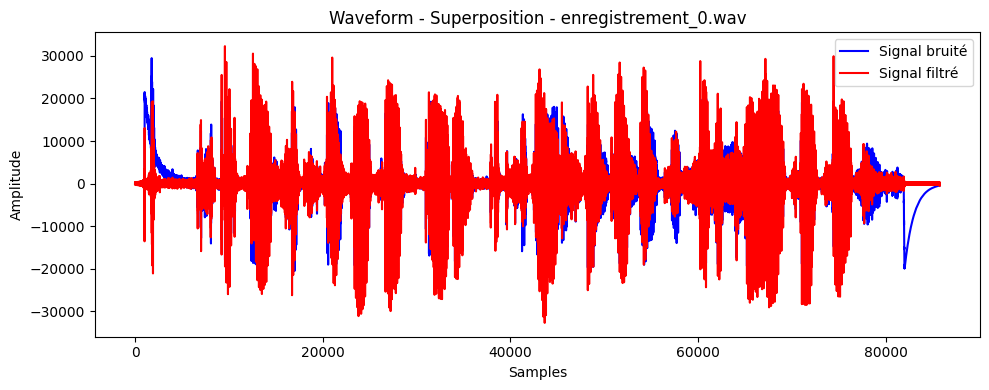

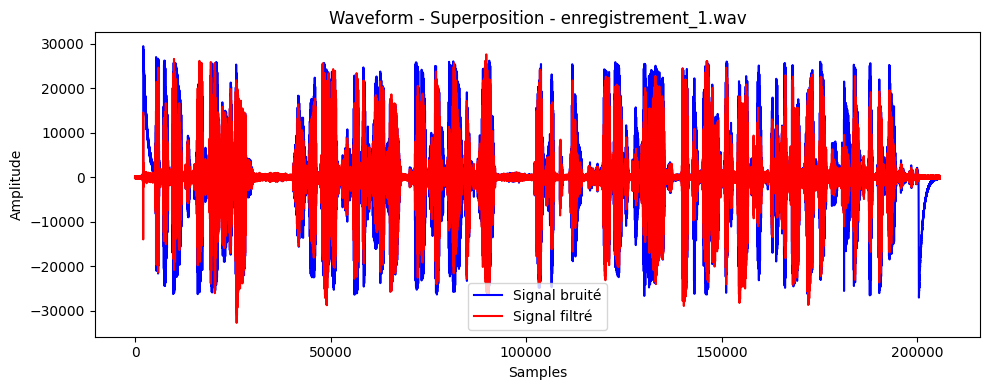

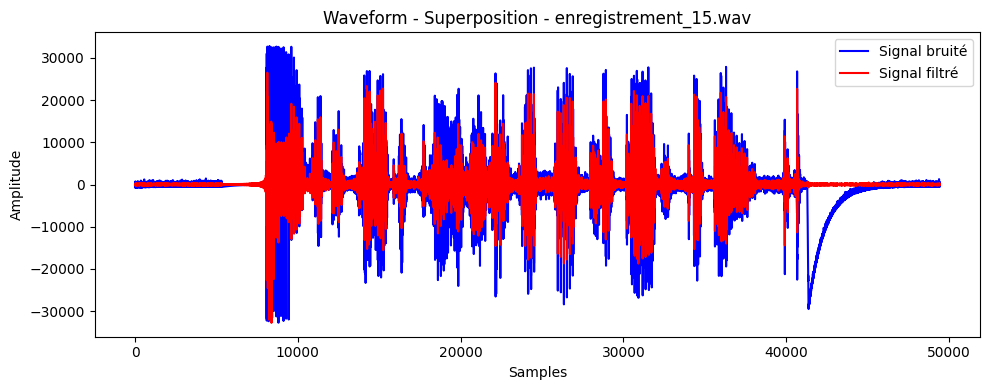

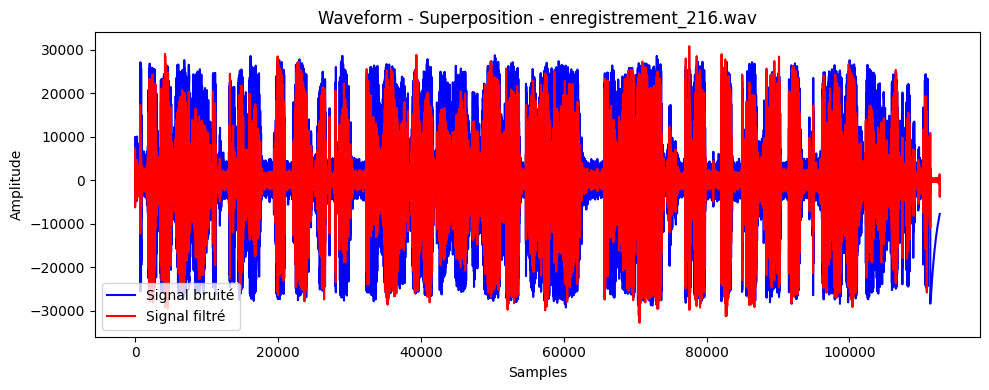

C:\Users\33647\AppData\Local\Temp\ipykernel_11176\1710876656.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\33647\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


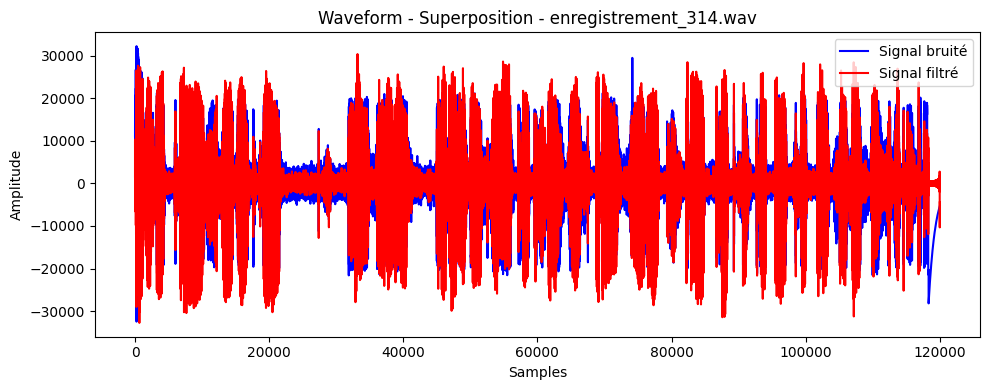

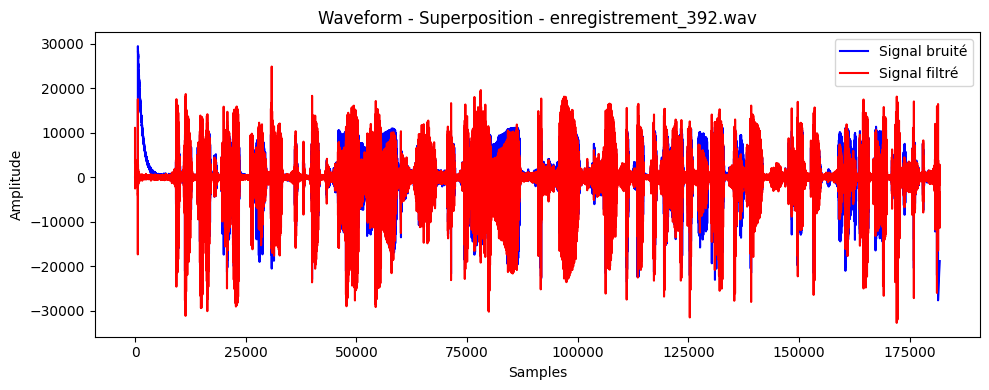

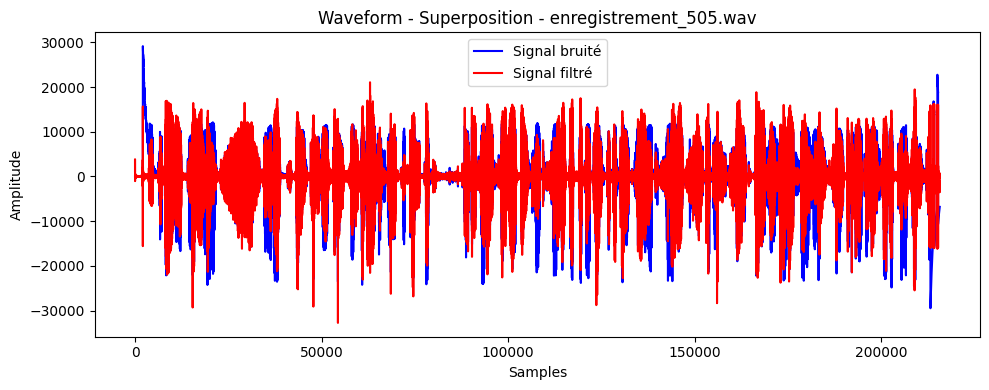

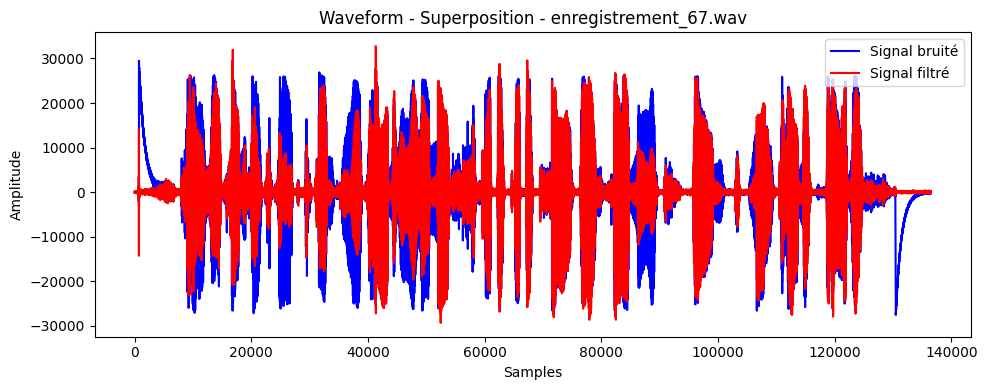

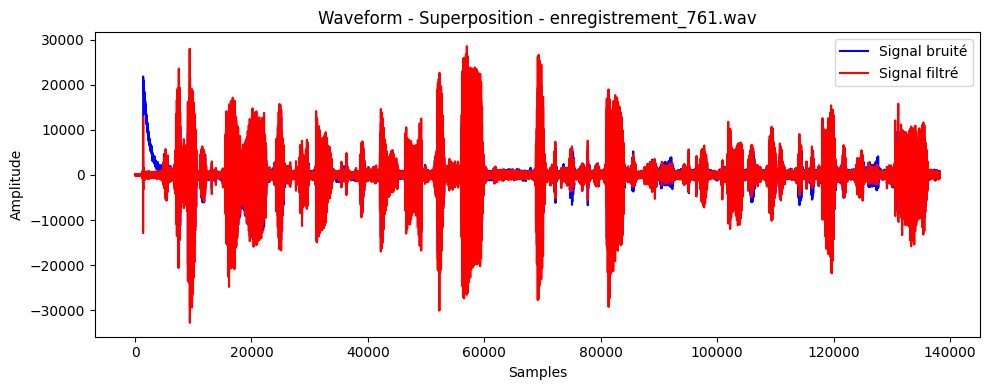

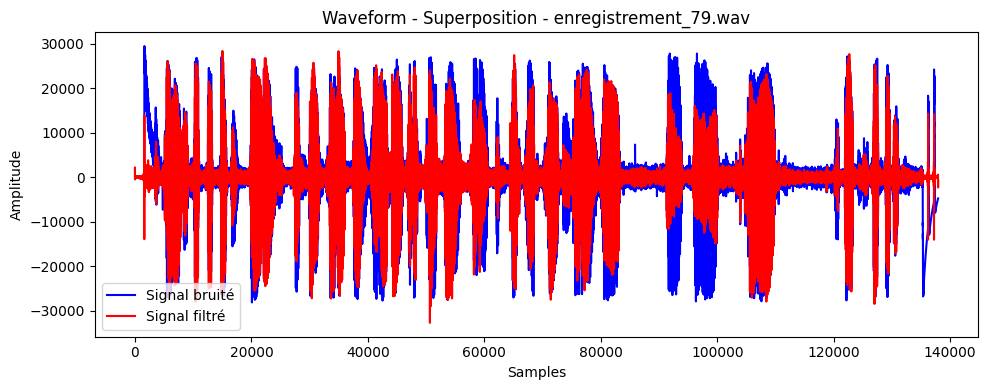

In [19]:
# Chemin vers les dossiers contenant les fichiers audio
noisy_data_folder = 'noisy_data'
filtered_data_folder = 'data_filtered_met1'

# Liste des fichiers audio non filtrés
noisy_audio_files = [f for f in os.listdir(noisy_data_folder) if f.endswith('.wav')]

# Parcours de chaque fichier audio non filtré
for noisy_file in noisy_audio_files:
    # Chemin complet du fichier audio non filtré
    noisy_filepath = os.path.join(noisy_data_folder, noisy_file)
    
    # Vérification de l'existence du fichier audio filtré correspondant
    filtered_filepath = os.path.join(filtered_data_folder, f'audio_filtre_{noisy_file[:-4]}_V450_2500.wav')
    if os.path.exists(filtered_filepath):
        # Lecture des signaux audio non filtré et filtré
        _, noisy_audio = wavfile.read(noisy_filepath)
        _, filtered_audio = wavfile.read(filtered_filepath)
        
        # Création du graphique pour la superposition des formes d'onde
        plt.figure(figsize=(10, 4))
        
        # Superposition des formes d'onde du signal audio non filtré (en bleu) et filtré (en rouge)
        plt.plot(noisy_audio, color='blue', label='Signal bruité')
        plt.plot(filtered_audio, color='red', label='Signal filtré')
        plt.title(f'Waveform - Superposition - {noisy_file}')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Aucun fichier filtré trouvé pour {noisy_file}")


### Tests de performances des différents méthodes

### Conclusion